## Train a FCN-VGG16

#### To train a Fully Convolutional Network based on Hamamatsu HCC VGG16 model. 
#### RGB image.
#### Very important to enable Transfer Learning.

2 classes: binary_crossentropy, sigmoid, mask(0, 255), flag_multi_class=False (chosen)

multi classes (2 included) : catocaries_crossentropy, softmax, mask(0, 1, 2, ...), flag_multi_class=True

In [1]:
from keras.models import load_model, Model
from keras import layers
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
model = load_model('E:\\deeplearning\\Hepatocarcinomes\\models\\5x\\vgg16_dense_bn\\best_model', compile = True)

weight_decay = 0.001
classes = 2

pool5 = model.get_layer("block5_pool").output
x = layers.Conv2D(4096, (1, 1), activation='relu', padding='valid', use_bias=False, name='dense_1', kernel_regularizer=l2(weight_decay))(pool5)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(512, (1, 1), activation='relu', padding='valid', name='dense_2', kernel_regularizer=l2(weight_decay))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='relu', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)
s32 = layers.UpSampling2D(size=(2,2),interpolation='bilinear')(x)

pool4 = model.get_layer("block4_pool").output
pool4 = layers.Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='relu', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(pool4)
s16 = layers.Add()([s32 , pool4])
s16 = layers.UpSampling2D(size=(2,2),interpolation='bilinear')(s16)

pool3 = model.get_layer("block3_pool").output
pool3 = layers.Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='relu', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(pool3)
s8 = layers.Add()([s16 , pool3])
s16 = layers.UpSampling2D(size=(8,8),interpolation='bilinear')(s8)

o_shape = Model(model.input, s16).output_shape
outputHeight = o_shape[1]
outputWidth = o_shape[2]

o = layers.Reshape((outputHeight*outputWidth, -1))(s16)
# o = layers.Reshape((-1, outputHeight*outputWidth))(s16)
# o = layers.Permute((2, 1))(o)
o = layers.Activation('softmax')(o)
model = Model(model.input, o)
# model.outputWidth = outputWidth
# model.outputHeight = outputHeight

# model_fcn = Model(inputs=model.input, outputs=s8)

In [3]:
# for layer in model.layers[0:19]:
#     layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

In [4]:
model.compile(optimizer = Adam(lr = 1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 32, 32, 64)   0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [6]:
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
#             for one pixel in the image, find the class in mask and convert it into one-hot vector
#             for mask: 1 means the first class, 2 means the second
            index = np.where(mask == i)
            index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
#         mask[mask > 0.5] = 1
#         mask[mask <= 0.5] = 0
    return (img,mask)

In [7]:
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

In [8]:
data_gen_args = dict(featurewise_std_normalization=True)

train_generator = trainGenerator(batch_size=64, train_path='E:\\deeplearning\\Hepatocarcinomes\\data\\5x\\training\\split64_image', image_folder='image_unet_train', mask_folder='mask_fcn_train', target_size = (64,64), image_color_mode = "rgb", aug_dict=data_gen_args, seed = 1, flag_multi_class=True)
validation_generator = trainGenerator(batch_size=64, train_path='E:\\deeplearning\\Hepatocarcinomes\\data\\5x\\training\\split64_image', image_folder='image_unet_val', mask_folder='mask_fcn_val', target_size = (64,64), aug_dict=data_gen_args, image_color_mode = "rgb", seed = 1, flag_multi_class=True)

csv_logger = CSVLogger('E:\\deeplearning\\Hepatocarcinomes\\models\\5x\\fcn_vgg16\\dense_lr3_64_ReLu_acc_training.csv', append=True)
model_checkpoint = ModelCheckpoint('E:\\deeplearning\\Hepatocarcinomes\\models\\5x\\fcn_vgg16\\dense_lr3_64_ReLu_acc_weights.{epoch:02d}-{val_acc:.4f}.hdf5', monitor='val_loss',verbose=1, save_best_only=True, period=5)
early_stop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=15, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, min_delta=0.01, cooldown=3, patience=9, min_lr=0.00001, verbose=1)
results = model.fit_generator(train_generator, steps_per_epoch=343,epochs=100, validation_data=validation_generator, validation_steps=68, callbacks=[csv_logger, model_checkpoint, early_stop, reduce_lr])
csv_logger.csv_file.close()

Epoch 1/100
Found 1100 images belonging to 1 classes.

C:\Program Files\Anaconda3\envs\r-tensorflow\lib\site-packages\keras_preprocessing\image\image_data_generator.py:346: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '



Found 5500 images belonging to 1 classes.


C:\Program Files\Anaconda3\envs\r-tensorflow\lib\site-packages\keras_preprocessing\image\utils.py:156: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 1100 images belonging to 1 classes.
Found 5500 images belonging to 1 classes.


C:\Program Files\Anaconda3\envs\r-tensorflow\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Program Files\Anaconda3\envs\r-tensorflow\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


343/343 [==============================] - 230s 670ms/step - loss: 1.3728 - acc: 0.6104 - val_loss: 2.6437 - val_acc: 0.5206
Epoch 2/100
343/343 [==============================] - 86s 251ms/step - loss: 0.7583 - acc: 0.7523 - val_loss: 4.2801 - val_acc: 0.4795
Epoch 3/100
343/343 [==============================] - 81s 237ms/step - loss: 0.5971 - acc: 0.7960 - val_loss: 0.6443 - val_acc: 0.7469
Epoch 4/100
343/343 [==============================] - 82s 238ms/step - loss: 0.5175 - acc: 0.8233 - val_loss: 0.6107 - val_acc: 0.7532
Epoch 5/100
343/343 [==============================] - 86s 250ms/step - loss: 0.4314 - acc: 0.8638 - val_loss: 0.6412 - val_acc: 0.7336

Epoch 00005: val_loss improved from inf to 0.64118, saving model to E:\deeplearning\Hepatocarcinomes\models\5x\fcn_vgg16\dense_lr3_64_ReLu_acc_weights.05-0.7336.hdf5
Epoch 6/100
343/343 [==============================] - 88s 257ms/step - loss: 0.3499 - acc: 0.9027 - val_loss: 0.5241 - val_acc: 0.8020
Epoch 7/100
343/343 [=======

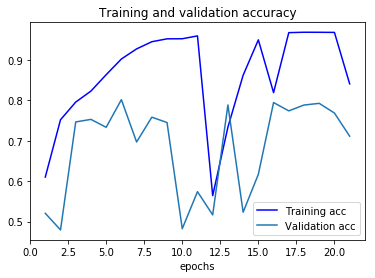

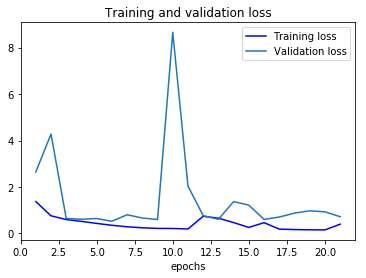

In [9]:
#plot training results
acc=results.history['acc']
val_acc=results.history['val_acc']
loss=results.history['loss']
val_loss=results.history['val_loss']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.ylabel('accuracy')
# plt.ylim((0, 5))

epochs=range(1, len(acc)+1)
plt.plot(epochs,acc,'b--',label='acc')
plt.plot(epochs, val_acc,'g',label='val_acc')
index0=np.where(val_acc==np.amax(val_acc))
for i in index0:
    plt.text(epochs[int(i)], val_acc[int(i)], str((epochs[int(i)], val_acc[int(i)])),color='g')
    
plt.title('Training and validation preformance')
plt.legend()

plt.subplot(2,1,2)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim((0, 5))

epochs=range(1, len(loss)+1)
plt.plot(epochs,loss,'b--',label='loss')
plt.plot(epochs, val_loss,'g',label='val_loss')
for i in index0:
    plt.text(epochs[int(i)], val_loss[int(i)], str((epochs[int(i)], val_loss[int(i)])),color='g')
    
plt.legend()
plt.savefig(path1+'\\adam_64_lr4_training_validation_performance')
plt.show()

In [10]:
model.save('E:\\deeplearning\\Hepatocarcinomes\\models\\5x\\fcn_vgg16\\dense_lr3_64_ReLu_acc_best_model.hdf5')